In [2]:
import pandas as pd

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

train_data_info = train_data.info()
test_data_info = test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230090 entries, 0 to 230089
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Date         230090 non-null  object
 1   store        230090 non-null  int64 
 2   product      230090 non-null  int64 
 3   number_sold  230090 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.0+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25550 entries, 0 to 25549
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         25550 non-null  object
 1   store        25550 non-null  int64 
 2   product      25550 non-null  int64 
 3   number_sold  25550 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 798.6+ KB


In [3]:
# Convert 'Date' column to datetime format
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_data['Date'] = pd.to_datetime(test_data['Date'])

# Set 'Date' as index for time series analysis
train_data.set_index('Date', inplace=True)
test_data.set_index('Date', inplace=True)

# Aggregate data by date to get total sales per day across all stores and products
train_daily_sales = train_data['number_sold'].resample('D').sum()
test_daily_sales = test_data['number_sold'].resample('D').sum()

# Display the first few rows of the aggregated daily sales data for train and test sets
train_daily_sales.head(), test_daily_sales.head()

(Date
 2010-01-01    54870
 2010-01-02    54960
 2010-01-03    54863
 2010-01-04    54926
 2010-01-05    54634
 Freq: D, Name: number_sold, dtype: int64,
 Date
 2019-01-01    55221
 2019-01-02    55287
 2019-01-03    55302
 2019-01-04    55407
 2019-01-05    55289
 Freq: D, Name: number_sold, dtype: int64)

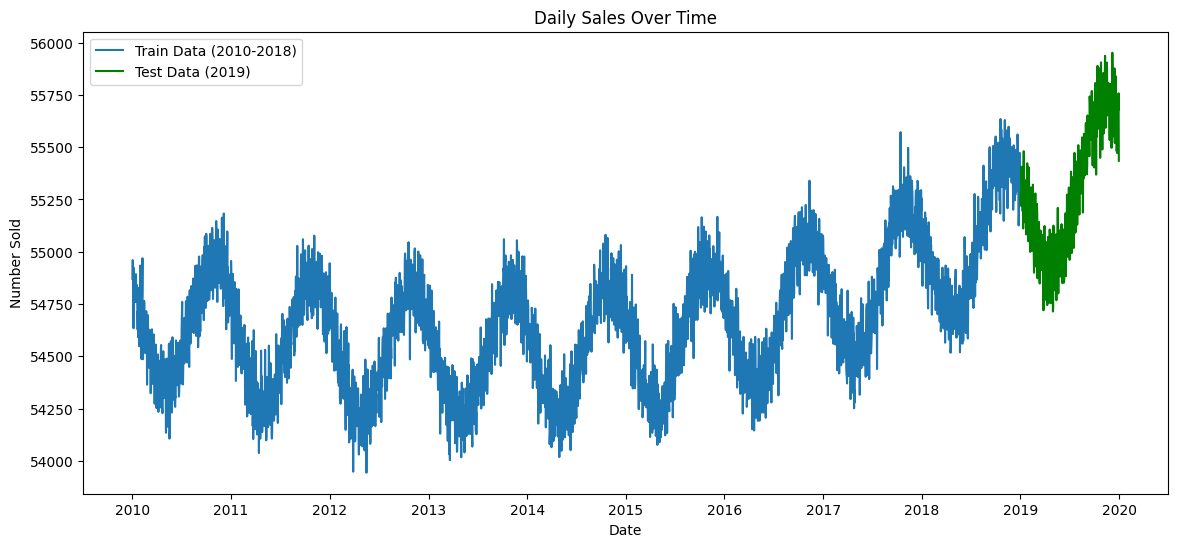

In [4]:
import matplotlib.pyplot as plt

# Plot the daily sales time series for training and testing data
plt.figure(figsize=(14, 6))
plt.plot(train_daily_sales, label="Train Data (2010-2018)")
plt.plot(test_daily_sales, label="Test Data (2019)", color='green')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.show()

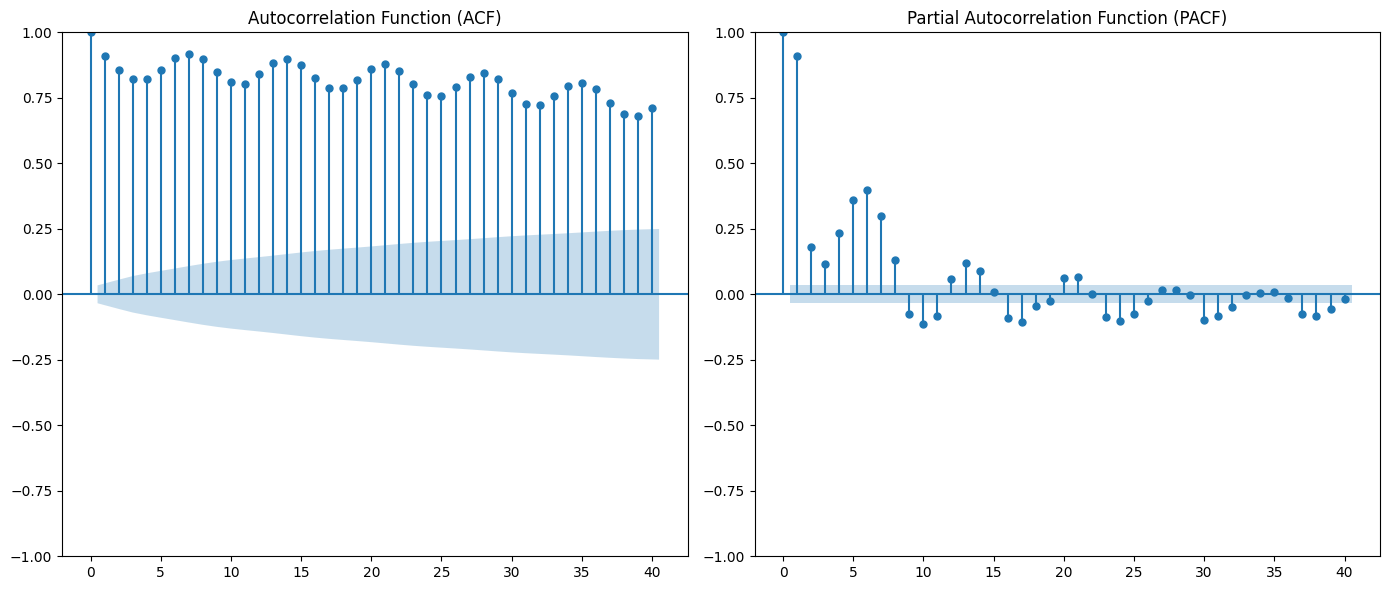

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the training data to determine p, d, q parameters
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plot_acf(train_daily_sales, lags=40, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

plt.subplot(1, 2, 2)
plot_pacf(train_daily_sales, lags=40, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

In [6]:
# Import SARIMAX for ARIMA model
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Define ARIMA model parameters (without seasonal components)
p, d, q = 1, 1, 1

# Fit the ARIMA model on training data
arima_model = SARIMAX(train_daily_sales, order=(p, d, q), seasonal_order=(0, 0, 0, 0))
arima_fit = arima_model.fit(disp=False)

# Summary of the ARIMA model
arima_summary = arima_fit.summary()
arima_summary

c:\Users\minak\Desktop\PythonProject\ArimaSarima\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            number_sold   No. Observations:                 3287
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -20210.113
Date:                Sat, 02 Nov 2024   AIC                          40426.226
Time:                        21:11:11   BIC                          40444.518
Sample:                    01-01-2010   HQIC                         40432.775
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3288      0.021     15.683      0.000       0.288       0.370
ma.L1         -0.8905      0.010    -86.414      0.000      -0.911      -0.870
sigma2      1.278e+04    323.003     39.560      0.000    1.21e+04    1.34e+04
===================================================================================
Ljung-Box (L1) (Q):                   8.84   Jarque-Bera (JB):                 1.61
Prob(Q):                              0.00   Prob(JB):                         0.45
Heteroskedasticity (H):               1.00   Skew:                             0.01
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [9]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Generate forecast for the test period
forecast = arima_fit.get_forecast(steps=len(test_daily_sales))
forecast_values = forecast.predicted_mean

# Calculate MAPE and RMSE
mape = mean_absolute_percentage_error(test_daily_sales, forecast_values)
rmse = np.sqrt(mean_squared_error(test_daily_sales, forecast_values))

print(f'MAPE: {mape} RMSE: {rmse}')

MAPE: 0.004974520531159938 RMSE: 316.61734521288315


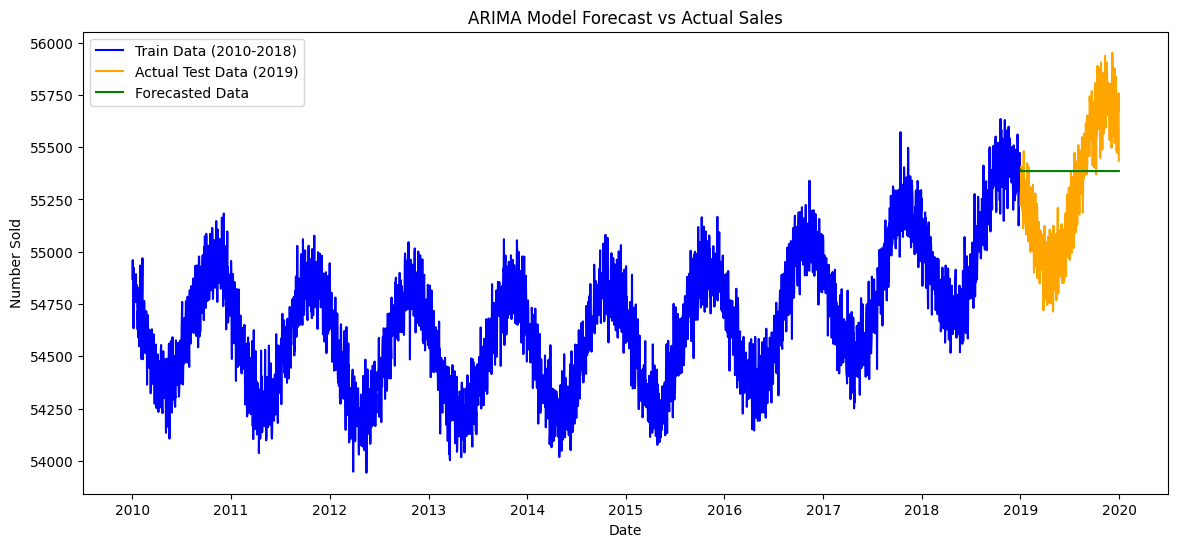

In [11]:
# Plot the actual test data and the forecasted values
plt.figure(figsize=(14, 6))
plt.plot(train_daily_sales, label="Train Data (2010-2018)", color='blue')
plt.plot(test_daily_sales, label="Actual Test Data (2019)", color='orange')
plt.plot(test_daily_sales.index, forecast_values, label="Forecasted Data", color='green')
plt.title("ARIMA Model Forecast vs Actual Sales")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.show()

Прогноз не ахти какой вышел.

C:\Users\minak\AppData\Local\Temp\ipykernel_32220\2250454163.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  train_monthly_sales = train_daily_sales.resample('M').sum()
C:\Users\minak\AppData\Local\Temp\ipykernel_32220\2250454163.py:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  test_monthly_sales = test_daily_sales.resample('M').sum()


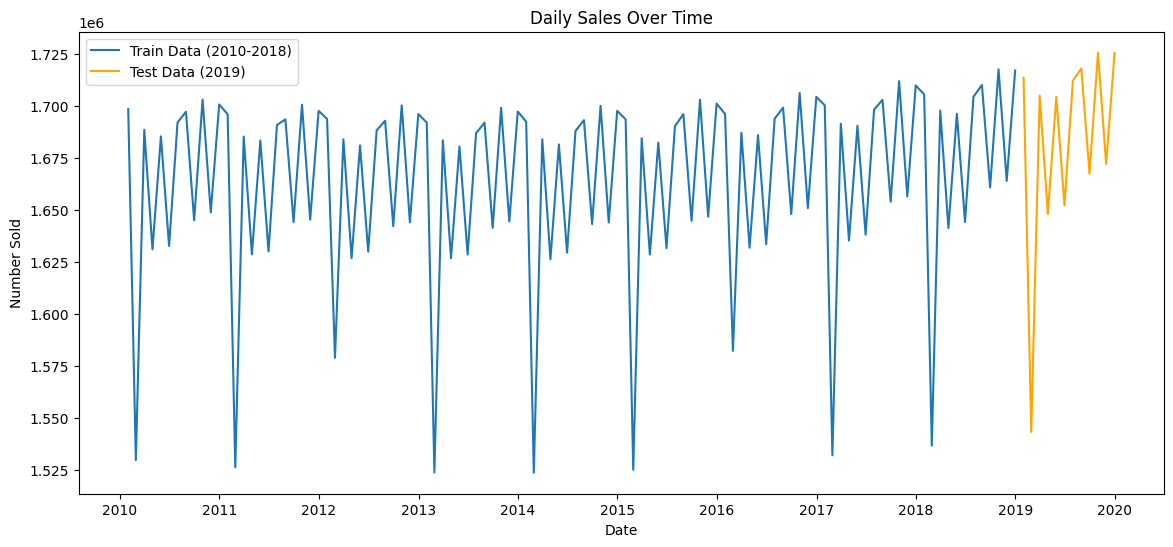

In [12]:
# Сжатие данных до месячных суммарных значений. Т.К, с дневными очень долого считается.
train_monthly_sales = train_daily_sales.resample('M').sum()
test_monthly_sales = test_daily_sales.resample('M').sum()


import matplotlib.pyplot as plt

# Plot the daily sales time series for training and testing data
plt.figure(figsize=(14, 6))
plt.plot(train_monthly_sales, label="Train Data (2010-2018)")
plt.plot(test_monthly_sales, label="Test Data (2019)", color='orange')
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.show()


c:\Users\minak\Desktop\PythonProject\ArimaSarima\env\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


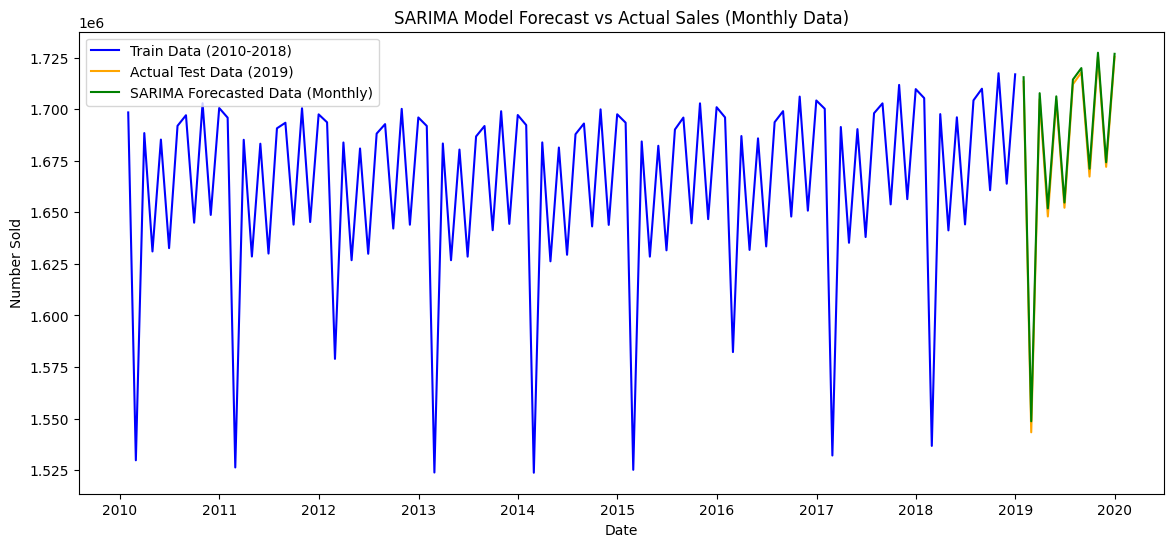

In [13]:
# Define SARIMA model parameters for monthly data with yearly seasonality (12 months)
p, d, q = 1, 1, 1
P, D, Q, s = 1, 1, 1, 12  # Monthly seasonality

# Fit the SARIMA model on monthly training data
sarima_model_monthly = SARIMAX(train_monthly_sales, order=(p, d, q), seasonal_order=(P, D, Q, s))
sarima_fit_monthly = sarima_model_monthly.fit(disp=True, maxiter=50)

# Generate forecast for the monthly test period
forecast_sarima_monthly = sarima_fit_monthly.get_forecast(steps=len(test_monthly_sales))
forecast_values_sarima_monthly = forecast_sarima_monthly.predicted_mean

# Plot the actual test data and the forecasted values for monthly SARIMA
plt.figure(figsize=(14, 6))
plt.plot(train_monthly_sales, label="Train Data (2010-2018)", color='blue')
plt.plot(test_monthly_sales, label="Actual Test Data (2019)", color='orange')
plt.plot(test_monthly_sales.index, forecast_values_sarima_monthly, label="SARIMA Forecasted Data (Monthly)", color='green')
plt.title("SARIMA Model Forecast vs Actual Sales (Monthly Data)")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.show()

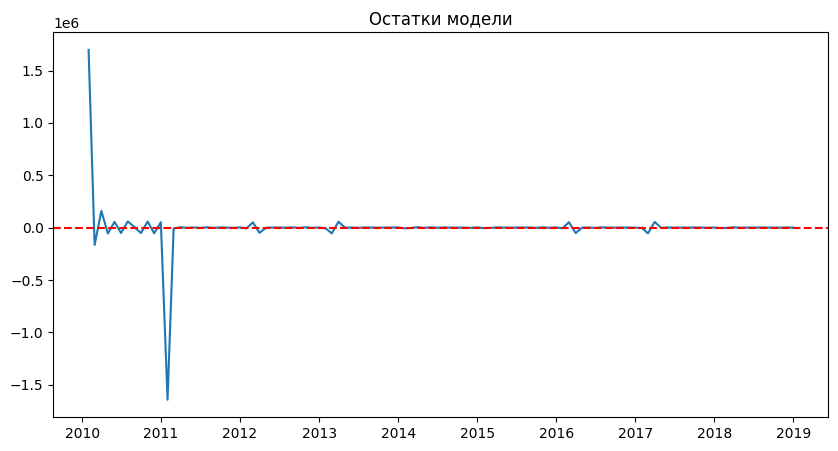

In [14]:
import matplotlib.pyplot as plt

# Получаем остатки
residuals = sarima_fit_monthly.resid

# График остатков
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Остатки модели')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

In [16]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

# Generate forecast for the test period
forecast = sarima_fit_monthly.get_forecast(steps=len(test_monthly_sales))
forecast_values = forecast.predicted_mean

# Calculate MAPE and RMSE
mape = mean_absolute_percentage_error(test_monthly_sales, forecast_values)
rmse = np.sqrt(mean_squared_error(test_monthly_sales, forecast_values))
r2 = r2_score(test_monthly_sales, forecast_values)

print(f'MAPE: {mape} RMSE: {rmse} R2: {r2}')

MAPE: 0.001634194085645072 RMSE: 2915.444310714317 R2: 0.996547382425799


Модель справилась намного лучше!

Обучем на тех же месячных данных ARIMA

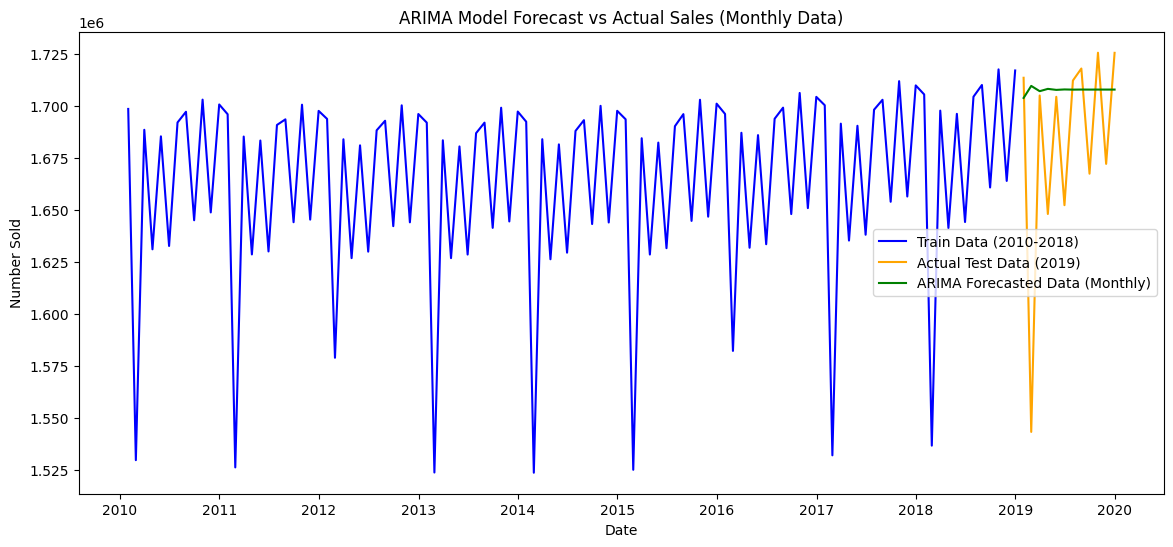

In [18]:
# Define ARIMA model parameters (without seasonal components)
p, d, q = 1, 1, 1

# Fit the ARIMA model on monthly training data
arima_model_monthly = SARIMAX(train_monthly_sales, order=(p, d, q), seasonal_order=(0, 0, 0, 0))
arima_fit_monthly = arima_model_monthly.fit(disp=True)

# Generate forecast for the monthly test period
forecast_arima_monthly = arima_fit_monthly.get_forecast(steps=len(test_monthly_sales))
forecast_values_arima_monthly = forecast_arima_monthly.predicted_mean

# Plot the actual test data and the forecasted values for monthly ARIMA
plt.figure(figsize=(14, 6))
plt.plot(train_monthly_sales, label="Train Data (2010-2018)", color='blue')
plt.plot(test_monthly_sales, label="Actual Test Data (2019)", color='orange')
plt.plot(test_monthly_sales.index, forecast_values_arima_monthly, label="ARIMA Forecasted Data (Monthly)", color='green')
plt.title("ARIMA Model Forecast vs Actual Sales (Monthly Data)")
plt.xlabel("Date")
plt.ylabel("Number Sold")
plt.legend()
plt.show()

Посчитаем метрики 

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

# Generate forecast for the test period
forecast = arima_fit_monthly.get_forecast(steps=len(test_monthly_sales))
forecast_values = forecast.predicted_mean

# Calculate MAPE and RMSE
mape = mean_absolute_percentage_error(test_monthly_sales, forecast_values)
rmse = np.sqrt(mean_squared_error(test_monthly_sales, forecast_values))
r2 = r2_score(test_monthly_sales, forecast_values)

print(f'MAPE: {mape} RMSE: {rmse} R2: {r2}')

MAPE: 0.021752704650951124 RMSE: 56317.04401686184 R2: -0.28830496112677273


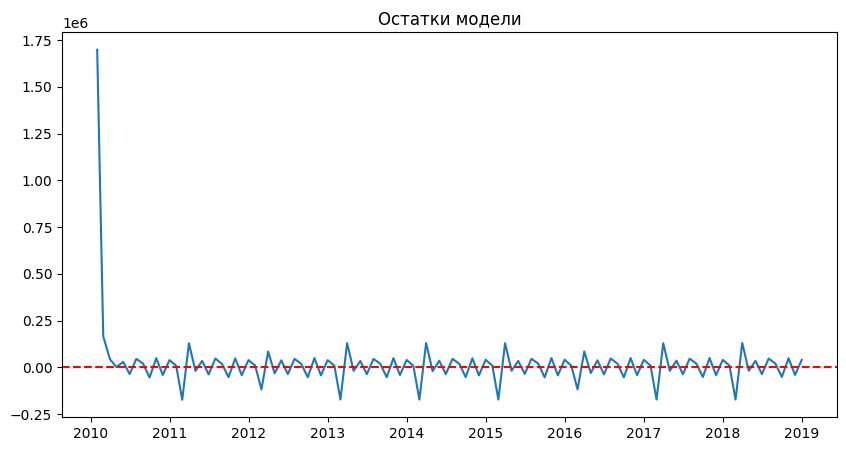

In [20]:
import matplotlib.pyplot as plt

# Получаем остатки
residuals = arima_fit_monthly.resid

# График остатков
plt.figure(figsize=(10, 5))
plt.plot(residuals)
plt.title('Остатки модели')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Простая ARIMA показывает с базовыми настройками показывает не лучший результат

Как видем SARIMA показала себя значительно лучше, за счет учета фактора сезонности!